In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from wallet import Wallet
import datetime
from pymongo import MongoClient
import time
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from coinoneTrader import get_orderbook, get_ticker

In [5]:
client = MongoClient("mongodb://mongo-191809ff-1.673dca44.cont.dockerapp.io:32768")
db = client.coinone
db.tickers.find().count()

978290

In [6]:
tickers_bson = db.tickers.find().limit(3000)
tickers_dic = list(tickers_bson)
tickers_df = pd.DataFrame(tickers_dic)
tickers_df = tickers_df[['datetime', 'last']]
tickers_df['datetime'] = pd.to_datetime(tickers_df['datetime'], "%Y-%m-%d %h:%m:%s")
tickers_df = tickers_df.set_index('datetime')

In [7]:
tickers_df['last'] = tickers_df['last'].astype(np.float)

In [29]:
# orderbooks_bson = db.orderbooks.find()
# orderbooks_dic = list(orderbooks_bson)
# orderbooks_df = pd.DataFrame(orderbooks_dic)

In [30]:
orderbooks_bson = db.orderbooks.find().limit(3000)

In [9]:
def simulate(n_iter=10):

    dict_lst = []

    for i in range(n_iter):
        orderbook = orderbooks_bson[i]
        bid_df = pd.DataFrame(orderbook['bid'])
        ask_df = pd.DataFrame(orderbook['ask'])
        selected_time = pd.to_datetime(orderbook['timestamp'], unit ='s')
    
        try:

            market_price = tickers_df.loc[selected_time, 'last']
            
        except:
            continue
        if type(market_price) == np.float64:
            position, price = get_position(bid_df, ask_df, delta=10)
            dict_lst.append({
                'datetime': selected_time,
                'market_price': market_price,
                'bid_ask_position': position,
                'price': price
            })



    tmp_df = pd.DataFrame(dict_lst)
    tmp_df = tmp_df.set_index('datetime')
    return tmp_df

In [10]:
def bid_ask_ratio(series):
    n_bid = np.sum(series == 'bid')
    n_ask = np.sum(series == 'ask')
    
    if n_ask == 0:
        return 0
    else:
        return n_bid / n_ask

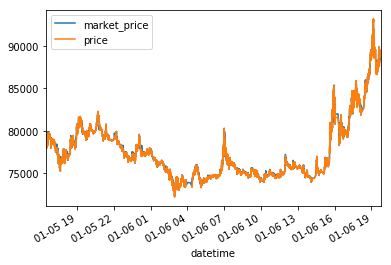

In [237]:
tmp_df = pd.read_csv("backst_90000.csv", parse_dates=True, index_col='datetime')
tmp_df.plot()

In [238]:
tmp_df['bid_ask_position'].tail()

datetime
2018-01-06 19:44:49    ask
2018-01-06 19:44:50    ask
2018-01-06 19:44:52    ask
2018-01-06 19:44:53    ask
2018-01-06 19:44:55    ask
Name: bid_ask_position, dtype: object

In [110]:
bid_ask_position = tmp_df['bid_ask_position'].resample('5S').apply(bid_ask_ratio)
tmp_df = tmp_df.resample('5S').last()
tmp_df['bid_ask_position'] = bid_ask_position

In [293]:
def run_simul():
    from wallet import Wallet
    wallet = Wallet(kw=1000000)
    # wallet.get_balance()

    for index in range(tmp_df.shape[0]):

        position_ratio = tmp_df.iloc[index,0]
        market_price = tmp_df.iloc[index,1]
        price = tmp_df.iloc[index,2]

        if market_price == price:
            if position_ratio == 0:
                continue
            elif position_ratio < 0.5:
                wallet.sell_qtum(-1, market_price)
            elif position_ratio > 2:
                wallet.buy_qtum(-1, market_price)
    return wallet

In [113]:
wallet = run_simul()
wallet.get_balance()

{'kw': 0.0, 'qtum': 13.55184581976113}

In [116]:
wallet.get_balance_in_kw(78000.0)

1055456.0260586319

In [100]:
wallet.total_transanction_fee

0.020358306188925084

In [101]:
wallet.get_trasanction_n()

1

In [8]:
from coinoneTrader import get_orderbook, get_ticker
from wallet import Wallet

In [22]:
def get_position(bid_df, ask_df, delta = 0):
    bid_df = bid_df.astype(np.float)
    ask_df = ask_df.astype(np.float)
    n_ask_influencer = ask_df[ask_df.qty > 50000]['price'].count()
    n_bid_influencer = bid_df[bid_df.qty > 50000]['price'].count()

    print('bid-ask-qty: ' + str(np.sum(bid_df.qty)) + ' / ' + str(np.sum(ask_df.qty)))
    print('')
    
    print('bid front: ')
    print(str(bid_df[['qty', 'price']].head(1)))
    print('')
    print('ask front: ')
    print(str(ask_df[['qty', 'price']].head(1)))
    print('')
    
    gap = abs(n_bid_influencer - n_ask_influencer)
    print('bid-ask: ' + str(n_bid_influencer) + '/' + str(n_ask_influencer) + ' [' + str(gap) + ']')
    
    if n_bid_influencer > 1.1 * n_ask_influencer:
        return ("bid", np.max(bid_df['price']) + delta)
    elif n_bid_influencer * 1.1 < n_ask_influencer:
        return ("ask", np.min(ask_df['price']) - delta)
    else:
        return ("tied", np.nan)


In [ ]:
COIN_NAME = 'xrp'
wallet = Wallet(kw=1000000)
while True:
    try:
        print("------------------")
        ticker = get_ticker(COIN_NAME)


        market_price = float(ticker['last'])

        orderbook = get_orderbook(COIN_NAME)
        ask_pd = pd.DataFrame(orderbook['ask'])
        ask_price = float(ask_pd.iloc[0, 0])

        bid_pd = pd.DataFrame(orderbook['bid'])
        bid_price = float(bid_pd.iloc[0, 0])
    except:
        continue
    
    position, price = get_position(bid_pd, ask_pd)
    price = float(price)

    print('')
    print('market / price : ' + str(market_price) + ' / ' + str(price) + ' ['+ str(abs(market_price - price)) +']')
    print('')


    if position == 'ask' and ((ask_price == market_price) or (ask_price <= bid_price and bid_price - 20 <= ask_price)):
#         if position == 'ask':
#     if position == 'ask' and ((ask_price == market_price) or (ask_price == bid_price)):
        print(position + ' sold')
        print('')
        wallet.sell_qtum(-1, market_price)

#     if position == 'bid' and ((bid_price == market_price) or (bid_price == ask_price)): 
    if position == 'bid' and ((bid_price == market_price) or (bid_price >= ask_price and ask_price + 20 >= bid_price)):

        print(position + ' bought')
        print('')
        wallet.buy_qtum(-1, market_price)


    
    print(wallet.get_balance())
    print('')
    print(wallet.get_balance_in_kw(market_price))
    time.sleep(0.8)


In [266]:
price

72010

In [295]:
def transform(index):
    tmp_selected = orderbooks_bson[index]
    tmp_selected_ask = pd.DataFrame(tmp_selected['ask'])
    tmp_selected_ask['timestamp'] = tmp_selected['timestamp']
    tmp_selected_ask['bid_ask'] = 'ask'

    tmp_selected_bid = pd.DataFrame(tmp_selected['bid'])
    tmp_selected_bid['timestamp'] = tmp_selected['timestamp']
    tmp_selected_bid['bid_ask'] = 'bid'
    return (tmp_selected_ask, tmp_selected_bid)
transformed_lst = []

for i in range(10000):
    transformed_ask, transformed_bid = transform(i)
    transformed_lst.append(transformed_ask)
    transformed_lst.append(transformed_bid)
    
transformed_df = pd.concat(transformed_lst)
transformed_df.to_csv("../rawdata/tranformed_df.csv")
transformed_df.head(10)